In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from matplotlib import gridspec

%matplotlib inline

plt.style.use('seaborn-white')
color = '#87ceeb'
az.style.use('arviz-darkgrid')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv("TherapeuticTouchData.csv", dtype={'s':'category'})
data.head()

,y,s
0,1,S01
1,0,S01
2,0,S01
3,0,S01
4,0,S01


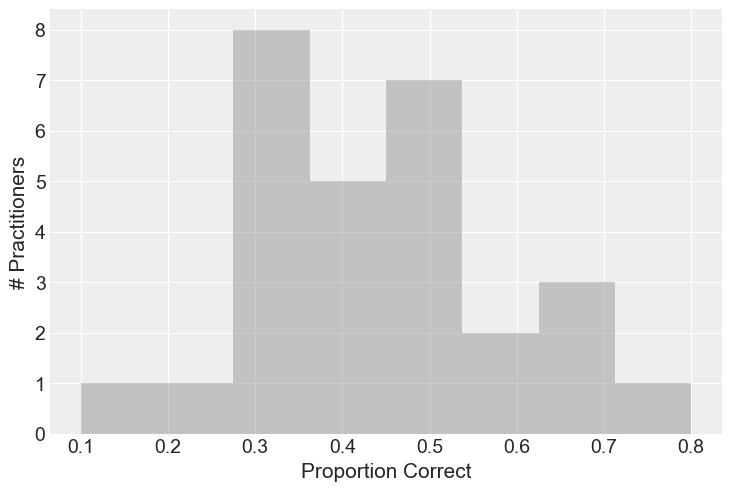

In [3]:
# 28 subjects with 10 tests per subject
# by chance we would expect the average to be 0.5 and for individual observations to be spread across (0,1)
# Plot the outcomes of the experiments


data_proportions = data.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(data_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

## Model

The outcome is binomial and we would expect if there are no effects from the "therapeutic touch", then the observed outcomes are random with a mean of 0.5*N (N=280).

As a Bayesian model we can use a Beta prior, but since we have 28 separate therapists, all trained by the same school, we can better model this question (hypothesis of no effect) using a hierarchical prior that accounts for  individual differences among therapists while measuring the global outcome among all therapists. Basically, we want to remove the effects of random extreme performance and find whether this therapy, as taught by the one school, shows a signifant effect while still treating the therapists as individual blocks of experiments.



## Reparameterizing the Beta Prior

The Beta is a conjugate prior for the binomial likelihood. The parameters of the Beta are $\alpha, \beta$. We can rewrite these as the mean, $\mu = \frac{\alpha}{\alpha + \beta}$ and the number of observations, $\kappa = \alpha + \beta$. So, $\alpha = \mu\kappa$ and $\beta = (1-\mu)\kappa$. Notice that this reparameterization behaves in a natural way, e.g., the standard deviation of the Beta is

$\sqrt{\frac{\mu(1-\mu)}{\kappa +1}}$

## Priors on Hyperparameters

Consider the prior for $\mu$ to be uniform (Beta(1,1)), which means that there is no prior emphasis on 0.5 or any other value. All all considered equally likely. The prior on the $\kappa$ is shifted to allow a flat distribution. This means that the range of performance among each practitioner is considered equally likely (i.e., broad range of performance).

Notice that the prior and posterior distributions are each joint distributions in 30 dimensional space for parameters, $\theta_1, \theta_2, \ldots, \theta_{28}$ and $\mu$ and $\kappa$.

In [4]:
conda install -c conda-forge python-graphviz

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


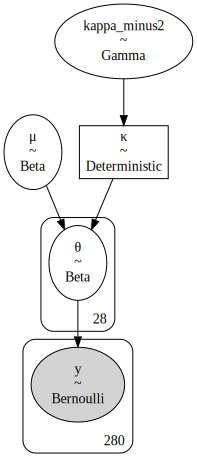

In [5]:
practitioner_idx = data.s.cat.codes.values
practitioner_codes = data.s.cat.categories
n_practitioners = practitioner_codes.size

with pm.Model() as hierarchical_model:
    μ = pm.Beta('μ', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01) # very steep for values near 0, but flat > 2
    κ = pm.Deterministic('κ', kappa_minus2 + 2)
    
    θ = pm.Beta('θ', alpha=μ*(κ-2)+1, beta=(1-μ)*(κ-2)+1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', θ[practitioner_idx], observed=data.y)    

pm.model_to_graphviz(hierarchical_model)

In [ ]:
with hierarchical_model:
    trace = pm.sample(5000, step = pm.NUTS(target_accept = 0.95), cores=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, kappa_minus2, μ]


In [ ]:
with hierarchical_model:
    pm.traceplot(trace, ['μ','κ', 'θ']);

In [ ]:
with hierarchical_model:
        print(pm.summary(trace))

In [ ]:
plt.figure(figsize=(10,12))
# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

# thetas and theta pairs to plot
thetas = (0, 13, 27)
theta_pairs = ((0,13),(0,27),(13,27))

font_d = {'size':14}

# kappa & mu posterior plots
for var, ax in zip(['κ', 'μ'], [ax1, ax2]):
    pm.plot_posterior(trace[var], point_estimate='mode', ax=ax, color=color, round_to=2)
    ax.set_xlabel('{}'.format(var), fontdict={'size':20, 'weight':'bold'})
ax1.set(xlim=(0,500))

# theta posterior plots
for var, ax in zip(thetas,[ax3, ax7, ax11]):
    pm.plot_posterior(trace['θ'][:,var], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('θ[{}]'.format(var), fontdict=font_d)

# theta scatter plots
for var, ax in zip(theta_pairs,[ax6, ax9, ax10]):
    ax.scatter(trace['θ'][::10,var[0]], trace['θ'][::10,var[1]], alpha=0.75, color=color, facecolor='none')
    ax.plot([0, 1], [0, 1], ':k', transform=ax.transAxes, alpha=0.5)
    ax.set_xlabel('θ[{}]'.format(var[0]), fontdict=font_d)
    ax.set_ylabel('θ[{}]'.format(var[1]), fontdict=font_d)
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal')

# theta posterior differences plots
for var, ax in zip(theta_pairs,[ax4, ax5, ax8]):
    pm.plot_posterior(trace['θ'][:,var[0]]-trace['θ'][:,var[1]], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('θ[{}] - θ[{}]'.format(*var), fontdict=font_d)

plt.tight_layout()

## Shrinkage

We can compare the results from the hierarchical prior model with a simple unpooled or no-pooling model that treats each of the practitioners in separate models. We could find these answers just using conjugate analysis, but let's look at the use of sampling and compare the results.

In [ ]:
with pm.Model() as unpooled_model:
    
    θ = pm.Beta('θ', 1, 1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', θ[practitioner_idx], observed=data.y)
    
pm.model_to_graphviz(unpooled_model)

In [ ]:
with unpooled_model:
    unpooled_trace = pm.sample(5000, cores=4)

In [ ]:
with unpooled_model:
    pm.traceplot(unpooled_trace, [ 'θ']);

Here we concatenate the trace results (thetas) from both models into a dataframe. Next we shape the data into a format that we can use with Seaborn's pointplot.

In [ ]:
df_shrinkage = (pd.concat([pm.summary(unpooled_trace).iloc[:,0],
                           pm.summary(trace).iloc[3:,0]],
                          axis=1)
                .reset_index())
df_shrinkage.columns = ['θ', 'unpooled', 'hierarchical']
df_shrinkage = pd.melt(df_shrinkage, 'θ', ['unpooled', 'hierarchical'], var_name='Model')
df_shrinkage.head()

In [ ]:
df_shrinkage.iloc[24:28,:]

The  plot below shows that the theta estimates on practitioner level are pulled towards the group mean of the hierarchical model.

In [ ]:
plt.figure(figsize=(10,9))
plt.scatter(1, pm.summary(trace).iloc[0,0], s=100, c='r', marker='x', zorder=999, label='Group mean')
sns.pointplot(x='Model', y='value', hue='θ', data=df_shrinkage);